# Score comparison analysis for meta-predictor

**Authorship:**
Adam Klie, *10/18/2021*
***
**Description:**
Notebook for ...
***
**TODOs:**
 - <font color='green'> Done TODO </font>
 - <font color='orange'> WIP TODO </font>
 - <font color='red'> Queued TODO </font>
***

In [1]:
# Classics
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Loading webpages
from scipy import stats
from IPython.display import IFrame
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pickle

# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
    
%autoreload 2

In [2]:
import sys
sys.path.append('/cellar/users/aklie/projects/EUGENE/bin/')
import project_utils

# GBM

In [3]:
DATASET = "2021-OLS-Library"  # Which dataset to look at
FEATURES = "mixed-2.0"  # What features to use to train the model
PREPROCESS = "0.18-0.4"  # Preprocessing steps, separated by "-"
HYPERPARAM = "selected"

# Load data

In [4]:
X = np.loadtxt('../data/{0}/{1}/X_{2}_{3}.txt'.format(DATASET.replace("-", "_"), FEATURES.replace("-", "_"), FEATURES, PREPROCESS), dtype=float)

In [5]:
y = np.loadtxt('../data/{0}/y_binary_{1}.txt'.format(DATASET.replace("-", "_"), PREPROCESS), dtype=int)
IDs = np.loadtxt('../data/{0}/sequence_id_{1}.txt'.format(DATASET.replace("-", "_"), PREPROCESS), dtype=str)
dataframe = pd.read_csv("../data/{0}/20210728-3.EnhancerTable.ForAdam.FunctionalEnhancers.WT-detected.ABL-notDetected.10R-20U-0.1P.tsv".format(DATASET.replace("-", "_")), sep="\t", na_values="na")
IDs[0], X[0], y[0], IDs.shape, X.shape, y.shape

('S1-G1R-S2-E1F-S3-E2F-S4-G2R-S5-G3F-S6',
 array([12. ,  0. ,  0. ,  0.9, -1. ,  2. ,  0.6,  1. ,  0. ,  0. ,  7. ,
         0.4,  1. ,  0. ,  0. ,  5. ,  0. ,  0. ,  0.3, -1. ,  0. ,  0. ,
         0. ,  0.5,  1. ,  0. ]),
 1,
 (302936,),
 (302936, 26),
 (302936,))

In [6]:
dataframe = dataframe[~dataframe["MPRA_FXN"].isna()].set_index("NAME")
dataframe.head(1)

,SEQUENCE,MPRA_FXN,MICROSCOPE_FXN,ACTIVITY_SUMRNA_NUMDNA
NAME,,,,
S1-G1R-S2-E1F-S3-E2F-S4-G2R-S5-G3F-S6,CATCTGAAGCTCGTTATCTCTAACGGAAGTTTTCGAAAAGGAAATT...,1.0,Neural Enhancer,0.611767


# Get the test set

## **Train/test split**

In [7]:
X_train, X_test, y_train, y_test, IDs_train, IDs_test = train_test_split(X, y, IDs, train_size=0.9, random_state=13)
X_train.shape, X_test.shape, y_train.shape, y_test.shape, IDs_train.shape, IDs_test.shape

((272642, 26), (30294, 26), (272642,), (30294,), (272642,), (30294,))

In [8]:
np.unique(y_train, return_counts=True)[1]/len(y_train), np.unique(y_test, return_counts=True)[1]/len(y_test)

(array([0.68878236, 0.31121764]), array([0.69115997, 0.30884003]))

In [9]:
file = "../data/{0}/{1}/{2}_header.txt".format(DATASET.replace("-", "_"), FEATURES.replace("-", "_"), FEATURES)
with open(file, "r") as f:
    features = [line.rstrip() for line in f.readlines()]

In [10]:
train_df = pd.DataFrame(X_train, columns=features, index=IDs_train)
train_df = pd.merge(dataframe, train_df, left_index=True, right_index=True)

In [11]:
test_df = pd.DataFrame(X_test, columns=features, index=IDs_test)
test_df = pd.merge(dataframe, test_df, left_index=True, right_index=True)

## **Standardize features**: *For mixed encoding only*

In [12]:
if FEATURES in ["block", "ohe-seq"]:
    scale_indeces = []  # Block and one-hot
elif FEATURES in ["mixed-1.0"]:
    scale_indeces = np.array([0, 3, 4, 7, 8, 11, 12, 15, 16, 19, 20])  # Mixed 1.0
elif FEATURES in ["mixed-2.0"]:   
    scale_indeces = np.array([0, 5, 10, 15, 20, 25])  # Mixed 2.0

In [13]:
X_scaled_train, X_scaled_test = project_utils.standardize_features(train_X=X_train, test_X=X_test, indeces=scale_indeces)
X_train[:, scale_indeces].mean(axis=0), X_train[:, scale_indeces].std(axis=0)

(array([-3.72156537e-17, -8.61328681e-17,  6.50101178e-17,  5.79083912e-17,
         3.13779041e-17,  1.27648650e-16]),
 array([1., 1., 1., 1., 1., 1.]))

# Load previously trained model

In [14]:
file = '../GBM/{}_{}_GBM-clf_{}.pickle'.format(PREPROCESS, FEATURES, HYPERPARAM)
clf = pickle.load(open(file, 'rb'))

In [15]:
y_tr_preds = clf.predict(X_train)
y_preds = clf.predict(X_test)

In [16]:
y_tr_probs = clf.predict_proba(X_train)[:, 1]
y_probs = clf.predict_proba(X_test)[:, 1]

# Analysis of missed predictions

#### Train

In [17]:
clf_train_df = pd.DataFrame(index=IDs_train, data={"labels": y_train, "GBM_preds":y_tr_preds, "GBM_probability":y_tr_probs})
clf_train_df.index.name = "NAME"
train_df = pd.merge(train_df, clf_train_df, left_index=True, right_index=True)
train_df["GBM_classification"] = ["-".join(list(value)) for value in train_df[["labels", "GBM_preds"]].values.astype(str)]
train_df["GBM_classification"] = train_df["GBM_classification"].replace({"0-0": "TN", "1-0": "FN", "0-1": "FP", "1-1": "TP"})
train_df["GBM_classification"].value_counts()
train_df["ACTIVITY_SUMRNA_NUMDNA"].replace(np.inf, np.nan, inplace=True)
train_df = train_df[np.abs(stats.zscore(train_df["ACTIVITY_SUMRNA_NUMDNA"], nan_policy="omit")) < 3]

#### Test

In [18]:
clf_test_df = pd.DataFrame(index=IDs_test, data={"labels": y_test, "GBM_preds":y_preds, "GBM_probability":y_probs})
clf_test_df.index.name = "NAME"
test_df = pd.merge(test_df, clf_test_df, left_index=True, right_index=True)
test_df["GBM_classification"] = ["-".join(list(value)) for value in test_df[["labels", "GBM_preds"]].values.astype(str)]
test_df["GBM_classification"] = test_df["GBM_classification"].replace({"0-0": "TN", "1-0": "FN", "0-1": "FP", "1-1": "TP"})
test_df["GBM_classification"].value_counts()
test_df["ACTIVITY_SUMRNA_NUMDNA"].replace(np.inf, np.nan, inplace=True)
test_df = test_df[np.abs(stats.zscore(test_df["ACTIVITY_SUMRNA_NUMDNA"], nan_policy="omit")) < 3]

# gkSVM

In [19]:
DATASET = "2021-OLS"  # Which dataset to look at
PREPROCESS = "0.18-0.4"  # Preprocessing steps, separated by "-"
HYPERPARAM = "baseline-positive-weighted"

# Load data

In [20]:
y = np.loadtxt('../data/{0}_Library/y_binary_{1}.txt'.format(DATASET.replace("-", "_"), PREPROCESS), dtype=int)
IDs = np.loadtxt('../data/{0}_Library/sequence_id_{1}.txt'.format(DATASET.replace("-", "_"), PREPROCESS), dtype=str)
dataframe = pd.read_csv("../data/{0}_Library/20210728-3.EnhancerTable.ForAdam.FunctionalEnhancers.WT-detected.ABL-notDetected.10R-20U-0.1P.tsv".format(DATASET.replace("-", "_")), sep="\t", na_values="na")
IDs[0], y[0], IDs.shape, y.shape

('S1-G1R-S2-E1F-S3-E2F-S4-G2R-S5-G3F-S6', 1, (302936,), (302936,))

In [21]:
dataframe = dataframe[~dataframe["MPRA_FXN"].isna()].set_index("NAME")
dataframe.head(1)

,SEQUENCE,MPRA_FXN,MICROSCOPE_FXN,ACTIVITY_SUMRNA_NUMDNA
NAME,,,,
S1-G1R-S2-E1F-S3-E2F-S4-G2R-S5-G3F-S6,CATCTGAAGCTCGTTATCTCTAACGGAAGTTTTCGAAAAGGAAATT...,1.0,Neural Enhancer,0.611767


In [22]:
# Make sure ordering is correct
pos_tr_scores = pd.read_csv('../gkSVM/Result_{0}-X-fasta_{1}_{2}/{0}-X-fasta_{1}_{2}.tr.predict.txt'.format(DATASET, PREPROCESS, HYPERPARAM), delim_whitespace=True, header=None, names=["NAME", "gkSVM_probability"])
neg_tr_scores = pd.read_csv('../gkSVM/Result_{0}-X-fasta_{1}_{2}/{0}-X-fasta_{1}_{2}.neg.tr.predict.txt'.format(DATASET, PREPROCESS, HYPERPARAM), delim_whitespace=True, header=None, names=["NAME", "gkSVM_probability"])
pos_scores = pd.read_csv('../gkSVM/Result_{0}-X-fasta_{1}_{2}/{0}-X-fasta_{1}_{2}.predict.txt'.format(DATASET, PREPROCESS, HYPERPARAM), delim_whitespace=True, header=None, names=["NAME", "gkSVM_probability"])
neg_scores = pd.read_csv('../gkSVM/Result_{0}-X-fasta_{1}_{2}/{0}-X-fasta_{1}_{2}.neg.predict.txt'.format(DATASET, PREPROCESS, HYPERPARAM), delim_whitespace=True, header=None, names=["NAME", "gkSVM_probability"])

In [23]:
len(pos_tr_scores), len(neg_tr_scores), len(pos_scores), len(neg_scores)

(84851, 187791, 9356, 20938)

In [24]:
pos_scores["gkSVM_labels"] = 1
pos_tr_scores["gkSVM_labels"] = 1
neg_scores["gkSVM_labels"] = 0
neg_tr_scores["gkSVM_labels"] = 0

In [25]:
pos_scores["gkSVM_preds"] = (pos_scores["gkSVM_probability"] >= 0).astype(int)
pos_tr_scores["gkSVM_preds"] = (pos_tr_scores["gkSVM_probability"] >= 0).astype(int)
neg_scores["gkSVM_preds"] = (neg_scores["gkSVM_probability"] >= 0).astype(int)
neg_tr_scores["gkSVM_preds"] = (neg_tr_scores["gkSVM_probability"] >= 0).astype(int)

In [26]:
clf_train_df = pd.concat([pos_tr_scores, neg_tr_scores]).set_index("NAME")
train_df = pd.merge(train_df, clf_train_df, left_index=True, right_index=True)
(train_df["labels"] == train_df["MPRA_FXN"]).all()
train_df["gkSVM_classification"] = ["-".join(list(value)) for value in train_df[["labels", "gkSVM_preds"]].values.astype(str)]
train_df["gkSVM_classification"] = train_df["gkSVM_classification"].replace({"0-0": "TN", "1-0": "FN", "0-1": "FP", "1-1": "TP"})
train_df["gkSVM_classification"].value_counts()
train_df["ACTIVITY_SUMRNA_NUMDNA"].replace(np.inf, np.nan, inplace=True)
train_df = train_df[np.abs(stats.zscore(train_df["ACTIVITY_SUMRNA_NUMDNA"], nan_policy="omit")) < 3]

In [27]:
clf_test_df = pd.concat([pos_scores, neg_scores]).set_index("NAME")
test_df = pd.merge(test_df, clf_test_df, left_index=True, right_index=True)
test_df["gkSVM_classification"] = ["-".join(list(value)) for value in test_df[["labels", "gkSVM_preds"]].values.astype(str)]
test_df["gkSVM_classification"] = test_df["gkSVM_classification"].replace({"0-0": "TN", "1-0": "FN", "0-1": "FP", "1-1": "TP"})
test_df["gkSVM_classification"].value_counts()
test_df["ACTIVITY_SUMRNA_NUMDNA"].replace(np.inf, np.nan, inplace=True)
test_df = test_df[np.abs(stats.zscore(test_df["ACTIVITY_SUMRNA_NUMDNA"], nan_policy="omit")) < 3]

In [34]:
(test_df["GBM_classification"] == test_df["gkSVM_classification"]).sum()

25744

TypeError: regplot() got an unexpected keyword argument 'stat_func'

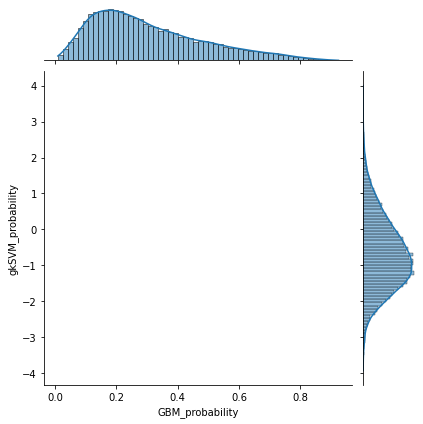

In [39]:
from scipy import stats
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2
sns.jointplot(data=test_df, x="GBM_probability", y="gkSVM_probability", kind="reg", stat_func=r2)

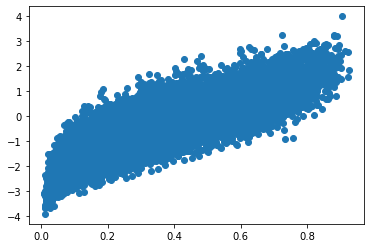

In [38]:
plt.scatter(

In [29]:
test_df.head(1)

,SEQUENCE,MPRA_FXN,MICROSCOPE_FXN,ACTIVITY_SUMRNA_NUMDNA,L1_length,TFBS1_ETS_affinity,TFBS1_ETS_orient,TFBS1_GATA_affinity,TFBS1_GATA_orient,L2_length,...,TFBS5_GATA_orient,L6_length,labels,GBM_preds,GBM_probability,GBM_classification,gkSVM_probability,gkSVM_labels,gkSVM_preds,gkSVM_classification
S1-G1F-S2-E1F-S3-E2R-S4-G2R-S5-G3F-S6,CATCTGAAGCTCGAGATAACTAACGGAAGTTTTCGAAATTTCCTTT...,0.0,NaN,0.059981,12.0,0.0,0.0,0.9,1.0,2.0,...,1.0,0.0,0,0,0.204348,TN,-1.06658,0,0,TN


# Scratch
